# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mglearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# 1. Data processing

In [52]:
# Load the datasets
all_data = pd.read_excel('alldata.xlsx')
questions1 = pd.read_excel('drq.xlsx')
questions2 = pd.read_excel('tv2q.xlsx')

# Reset indices to ensure uniqueness
all_data = all_data.reset_index(drop=True)
questions1 = questions1.reset_index(drop=True)
questions2 = questions2.reset_index(drop=True)

# Merge datasets
df = pd.concat([all_data, questions1, questions2], axis=1)

# List of ids to drop
ids_to_drop = [
    'bornholm-1', 'bornholm-2', 'bornholm-3', 'bornholm-4', 'bornholm-5',
    'fyns-1', 'fyns-2', 'fyns-3', 'fyns-4', 'fyns-5',
    'københavns omegns-1', 'københavns omegns-2', 'københavns omegns-3', 'københavns omegns-4', 'københavns omegns-5',
    'københavns-1', 'københavns-2', 'københavns-3', 'københavns-4', 'københavns-5',
    'nordjyllands-1', 'nordjyllands-2', 'nordjyllands-3', 'nordjyllands-4', 'nordjyllands-5',
    'nordsjællands-1', 'nordsjællands-2', 'nordsjællands-3', 'nordsjællands-4', 'nordsjællands-5',
    'sjællands-1', 'sjællands-2', 'sjællands-3', 'sjællands-4', 'sjællands-5',
    'sydjyllands-1', 'sydjyllands-2', 'sydjyllands-3', 'sydjyllands-4', 'sydjyllands-5',
    'vestjyllands-1', 'vestjyllands-2', 'vestjyllands-3', 'vestjyllands-4', 'vestjyllands-5',
    'østjyllands-1', 'østjyllands-2', 'østjyllands-3', 'østjyllands-4', 'østjyllands-5'
]

# Drop the rows whose id is in the ids_to_drop list
df = df[~df['id'].isin(ids_to_drop)]

# Drop rows where any row has a NaN
cleaned_df = df.dropna()

# Drop rows where all values are NaN
cleaned_df = df.dropna(how='all')

# Drop columns with any NaN values
cleaned_df = df.dropna(axis=1)

# Display the merged dataset to ensure correctness
display(cleaned_df.head())

ERROR: Could not find a version that satisfies the requirement IPhyton (from versions: none)
ERROR: No matching distribution found for IPhyton


,530,531,533,534,535,537,538,540,541,543,...,9a,9b,10a,10b,11a,11b,12a,12b,storkreds,alder
50,-1,-1,2,2,1,-1,-1,-1,-1,1,...,0,0,1,2,-1,2,0,1,Østjyllands Storkreds,44
51,1,1,2,1,2,-1,-2,1,-1,1,...,1,-1,1,2,0,2,1,0,Østjyllands Storkreds,56
52,-1,-1,1,1,2,1,-2,1,-1,1,...,1,-1,0,1,-2,2,1,-1,Østjyllands Storkreds,21
53,-1,1,2,-2,1,-2,-2,2,-2,1,...,2,2,2,-2,-2,2,2,2,Østjyllands Storkreds,73
54,1,1,1,-2,2,2,-2,1,1,1,...,2,1,1,-1,-2,2,1,1,Østjyllands Storkreds,45


In [53]:

# Define custom color palette
party_colors_palette = {
    "Socialdemokratiet": "red",
    "Radikale Venstre": "#713280",
    "Det Konservative Folkeparti": "#9EBA27",
    "Nye Borgerlige": "#054F5C",
    "Socialistisk Folkeparti": "#DD0878",
    "Liberal Alliance": "#21C6CF",
    "Kristendemokraterne": "#BABABA",
    "Moderaterne": "#6C39E5",
    "Dansk Folkeparti": "#F3CD41",
    "Frie Grønne, Danmarks Nye Venstrefløjsparti": "#00E66A",
    "Enhedslisten": "#2A8F39",
    "Venstre": "#006697",
    "Danmarksdemokraterne": "#8AC3FF",
    "Alternativet": "#ED8019",
    "Løsgænger": "brown"
}


# 2. Dimensionality Reduction

In [54]:
from sklearn.preprocessing import LabelEncoder

# Exclude non needed columns
pca_df = cleaned_df.drop(['storkreds', 'alder','navn'], axis=1)

# Fit the encoder to the 'parti' column and transform it to integers
encoder = LabelEncoder()
pca_df['parti'] = encoder.fit_transform(pca_df['parti'])

# Extract features (question answers) from the merged dataset
features = pca_df.iloc[:, :50]  # Assuming the first 50 columns are the features

scaler = StandardScaler()
scaler.fit(pca_df)
X_scaled = scaler.transform(pca_df)
display(pca_df)

,530,531,533,534,535,537,538,540,541,543,...,8a,8b,9a,9b,10a,10b,11a,11b,12a,12b
50,-1,-1,2,2,1,-1,-1,-1,-1,1,...,0,1,0,0,1,2,-1,2,0,1
51,1,1,2,1,2,-1,-2,1,-1,1,...,-1,1,1,-1,1,2,0,2,1,0
52,-1,-1,1,1,2,1,-2,1,-1,1,...,1,1,1,-1,0,1,-2,2,1,-1
53,-1,1,2,-2,1,-2,-2,2,-2,1,...,2,0,2,2,2,-2,-2,2,2,2
54,1,1,1,-2,2,2,-2,1,1,1,...,2,1,2,1,1,-1,-2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,1,1,1,-2,2,-1,1,-2,1,1,...,2,1,1,2,-1,2,1,-2,0,0
863,1,-2,-2,-2,1,-2,-1,-2,-2,-2,...,1,0,-1,0,-1,2,2,-2,0,0
864,1,1,1,-2,2,-1,1,-1,-1,1,...,1,0,-1,0,-1,2,2,-2,0,1
865,1,-1,1,-2,1,-1,-1,-1,-1,1,...,0,0,0,0,0,2,1,-2,1,0


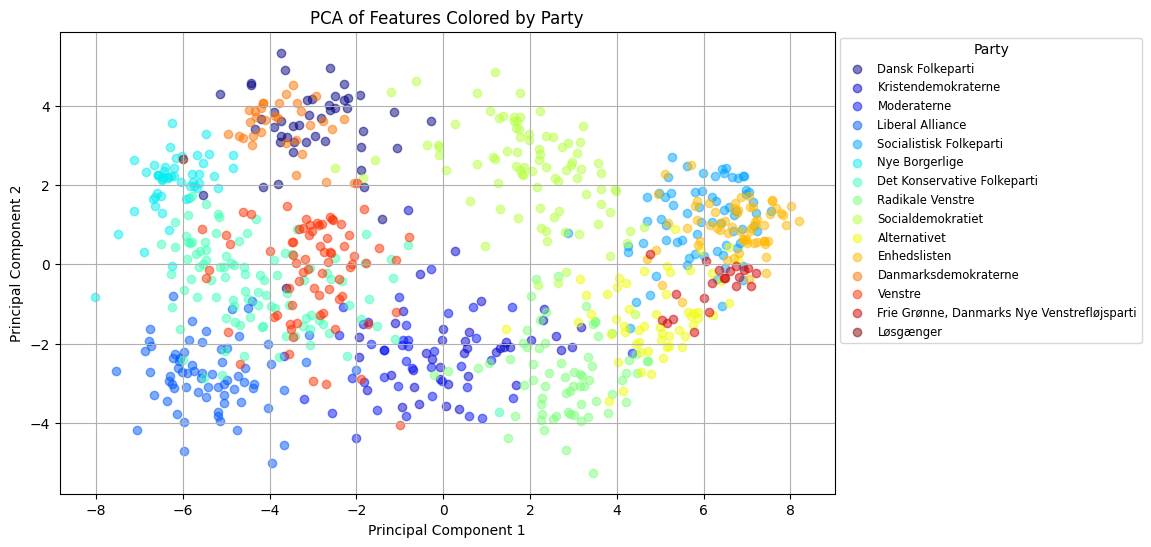

In [55]:

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Mapping unique labels to colors
unique_labels = df['parti'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# Plot the PCA components
plt.figure(figsize=(10, 6))
for label, color in color_map.items():
    idx = df['parti'] == label
    plt.scatter(components[idx, 0], components[idx, 1], alpha=0.5, color=color, label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Features Colored by Party')
plt.grid(True)

# Create a legend
plt.legend(title='Party',loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

plt.clim(-0.5, len(unique_labels) - 0.5)

plt.show()

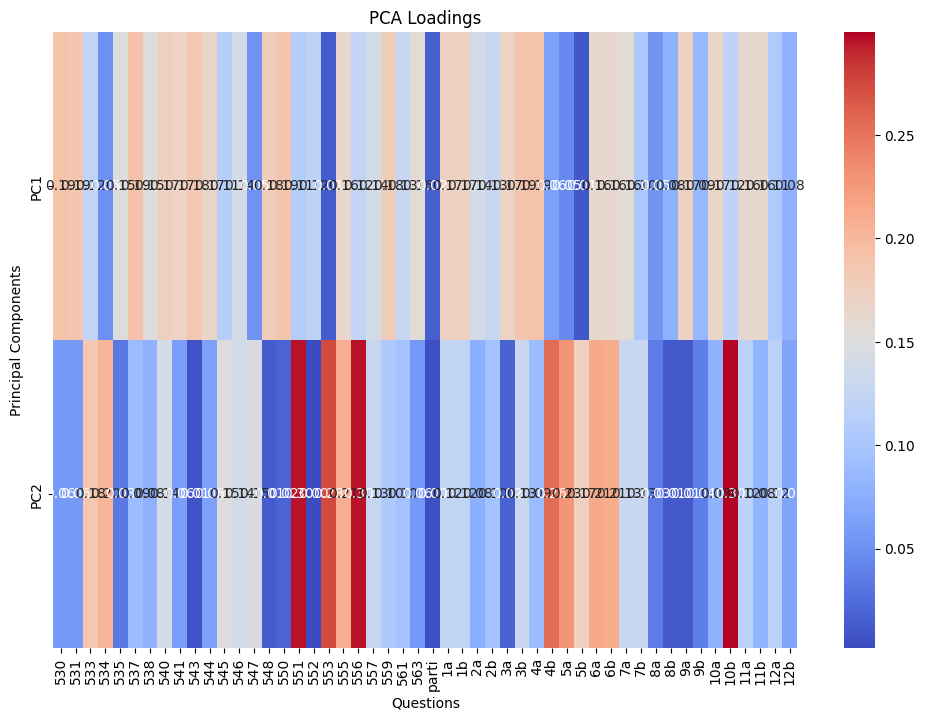

In [56]:
# Get the absolute values of PCA components to represent their influence
pca_components_abs = abs(pca.components_)

# Create a DataFrame to store the loadings of each question on the principal components
loadings_df = pd.DataFrame(pca_components_abs, columns=features.columns, index=['PC1', 'PC2'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA Loadings')
plt.xlabel('Questions')
plt.ylabel('Principal Components')
plt.show()

In [57]:
# Get the absolute loadings of each question on PC1 and PC2
loadings_pc1 = loadings_df.loc['PC1'].abs()
loadings_pc2 = loadings_df.loc['PC2'].abs()

# Sort the loadings in descending order to identify the most crucial questions
sorted_loadings_pc1 = loadings_pc1.sort_values(ascending=False)
sorted_loadings_pc2 = loadings_pc2.sort_values(ascending=False)

# Display the top 10 most crucial questions for each principal component
print("Top 10 Most Crucial Questions for Principal Component 1:")
print(sorted_loadings_pc1.head(10))
print("\nTop 10 Most Crucial Questions for Principal Component 2:")
print(sorted_loadings_pc2.head(10))

Top 10 Most Crucial Questions for Principal Component 1:
537    0.190767
530    0.189977
4a     0.189487
550    0.188353
3b     0.187879
531    0.186152
543    0.184709
559    0.177012
548    0.176458
540    0.174966
Name: PC1, dtype: float64

Top 10 Most Crucial Questions for Principal Component 2:
10b    0.299811
551    0.296158
556    0.295492
553    0.275003
4b     0.255436
5a     0.228790
6a     0.213436
6b     0.210262
555    0.209532
534    0.202784
Name: PC2, dtype: float64


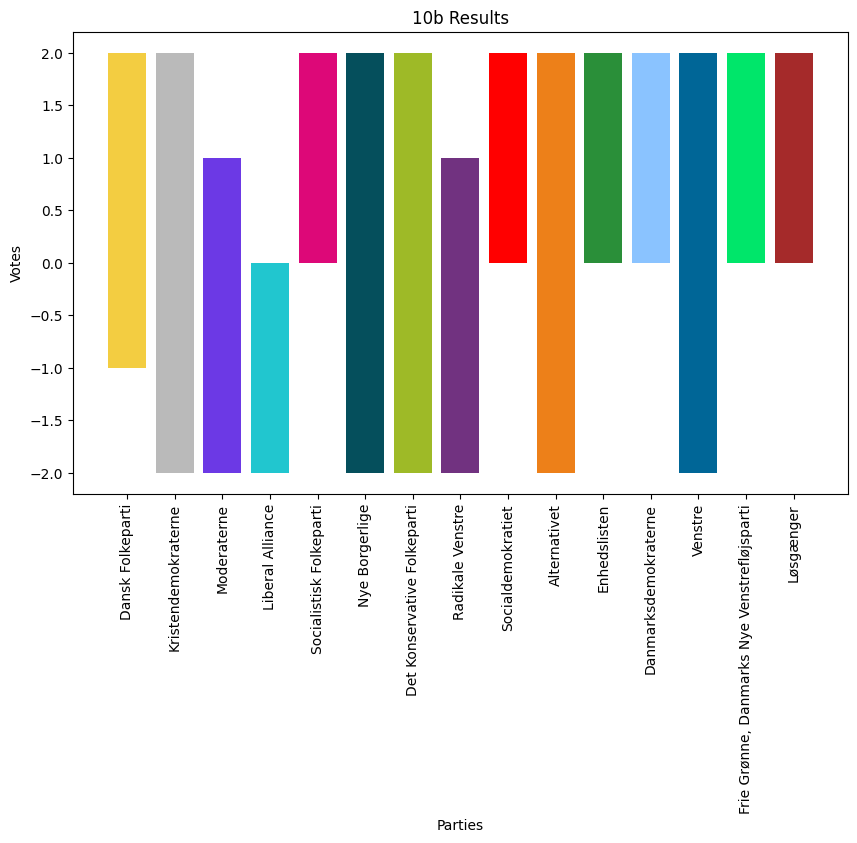

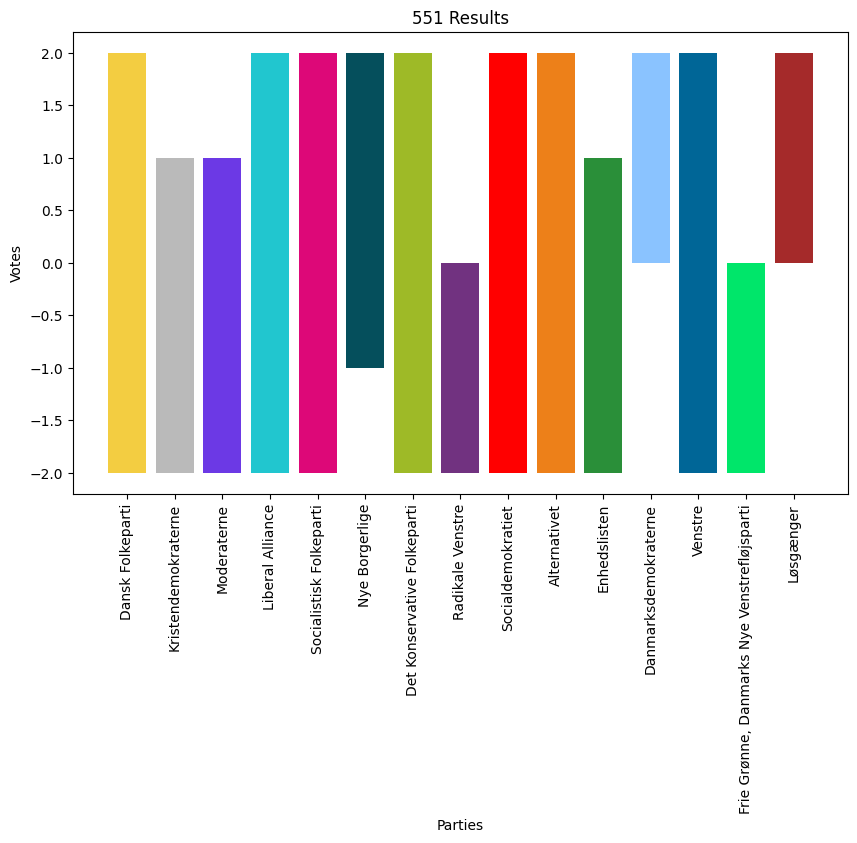

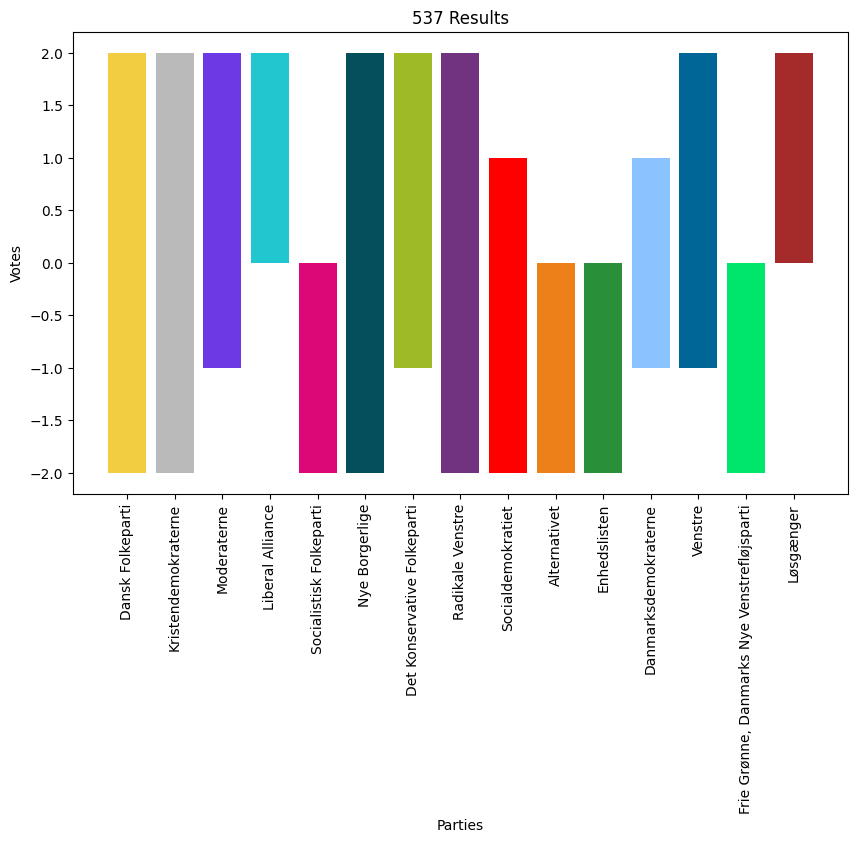

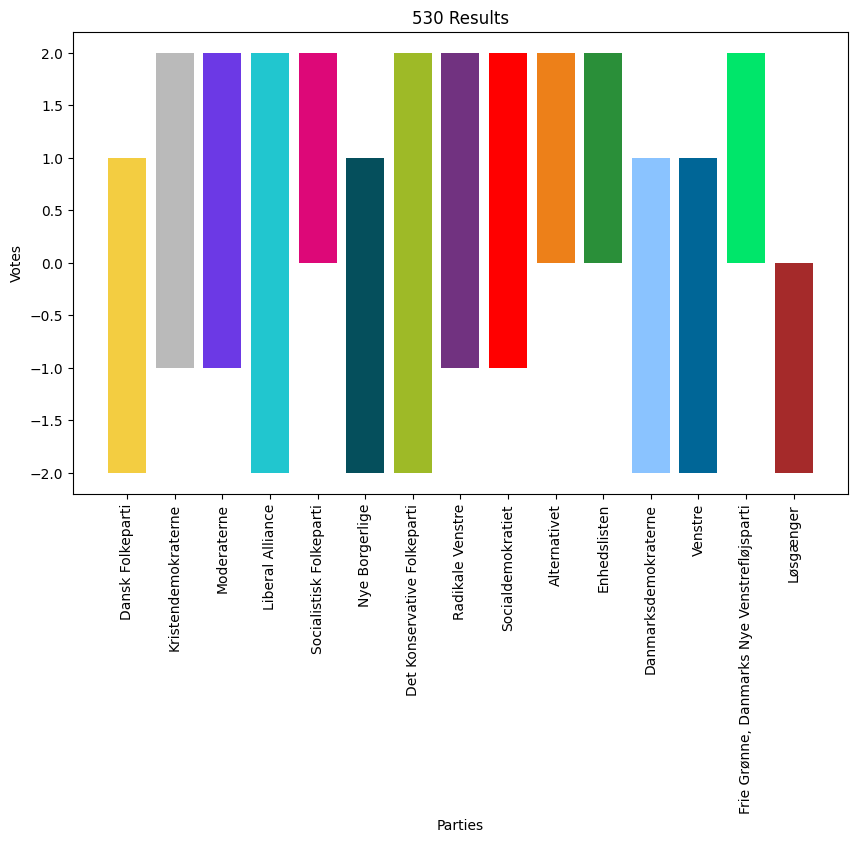

In [58]:
parties = cleaned_df["parti"]
colors = [party_colors_palette[party] for party in parties]

questions = ["10b","551","537","530"]

for question in questions:
    votes = cleaned_df[question]
    # Creating the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(parties, votes, color=colors)
    plt.xlabel('Parties')
    plt.ylabel('Votes')
    plt.title(question + ' Results')
    plt.xticks(rotation=90)
    plt.show()

# t-SNE

Number of samples: (817, 49)


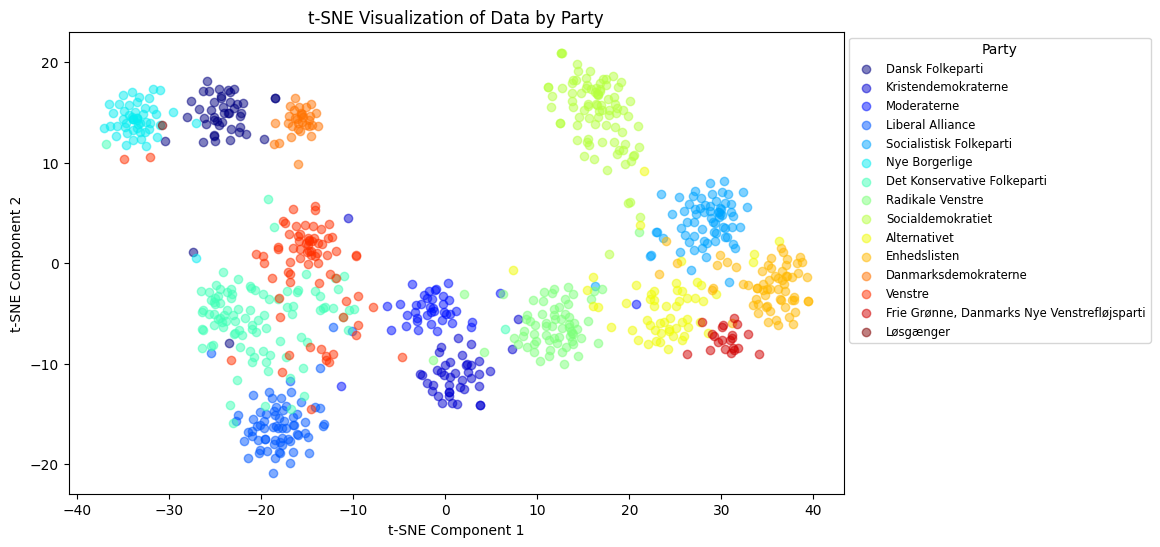

In [59]:
X = cleaned_df.drop(['storkreds', 'alder','navn', 'parti'], axis=1)
y = cleaned_df['parti']

#Convert from panda_series to dataframe
X_df = pd.DataFrame(X)

#Check number of samples to be sure it has enough samples
print("Number of samples:", X_df.shape)

#Initialize TSNE, set 2 components, perplexity to 30.
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
X_tsne = tsne.fit_transform(X_df)

#Set colors
unique_labels = df['parti'].unique()  # Directly using party names, if available
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))
plt.figure(figsize=(10, 6))
for label, color in color_map.items():
    idx = df['parti'] == label  # Index based directly on names, no ID-to-name conversion needed
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], alpha=0.5, color=color, label=label)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Data by Party')
plt.legend(title='Party', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.show()

# 3. Clustering Analysis

K-means clustering

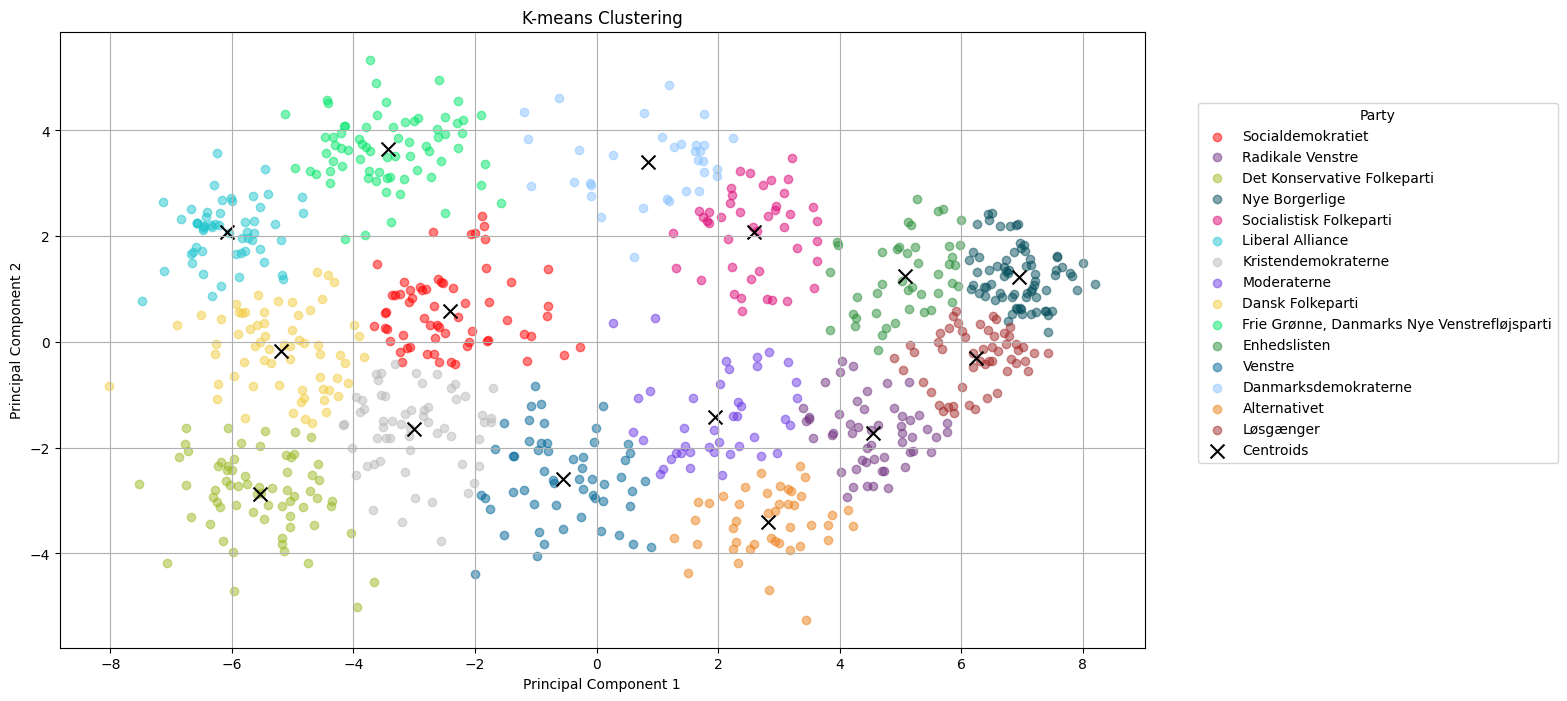

In [60]:
# Apply k-means clustering
n_clusters = 15  # Number of political parties
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(components)

# Get cluster labels and cluster centers
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Map cluster labels to party names
cluster_party_names = {i: party for i, party in enumerate(party_colors_palette.keys())}

# Map cluster labels to colors
cluster_colors = [party_colors_palette[party] for party in party_colors_palette]

# Plot the clusters with distinct colors
fig = plt.figure(figsize=(14, 8))

# Plot the clusters
for i in range(n_clusters):
    plt.scatter(components[cluster_labels == i, 0], components[cluster_labels == i, 1],
                color=cluster_colors[i], alpha=0.5, label=cluster_party_names[i])

# Plot centroids
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, c='black', label='Centroids')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering')

fig.legend(loc='upper right', title='Party', bbox_to_anchor=(1.2, 0.8))

plt.grid(True)
plt.show()

Which parties agree or disagree the most?

In [61]:
# Calculate the average position of each party in the reduced-dimensional space
party_positions = {}
for party, color in party_colors_palette.items():
    party_positions[party] = components[cleaned_df['parti'] == party].mean(axis=0)

# Convert party positions dictionary to DataFrame for easier manipulation
party_positions_df = pd.DataFrame.from_dict(party_positions, orient='index', columns=['PC1', 'PC2'])

# Display the average positions of parties
print("Average Positions of Parties:")
print(party_positions_df)


Average Positions of Parties:
                                                  PC1       PC2
Socialdemokratiet                            2.008136  2.335604
Radikale Venstre                             2.805731 -2.781919
Det Konservative Folkeparti                 -4.208238 -0.532465
Nye Borgerlige                              -6.212418  2.034713
Socialistisk Folkeparti                      5.974640  1.055173
Liberal Alliance                            -5.361940 -2.776072
Kristendemokraterne                          0.377848 -2.082403
Moderaterne                                 -0.669649 -2.402480
Dansk Folkeparti                            -3.027080  3.455285
Frie Grønne, Danmarks Nye Venstrefløjsparti  6.205851 -0.563241
Enhedslisten                                 6.708524  0.933561
Venstre                                     -3.008729 -0.178209
Danmarksdemokraterne                        -3.704691  3.504366
Alternativet                                 4.860311 -1.305455
Løsgænger 

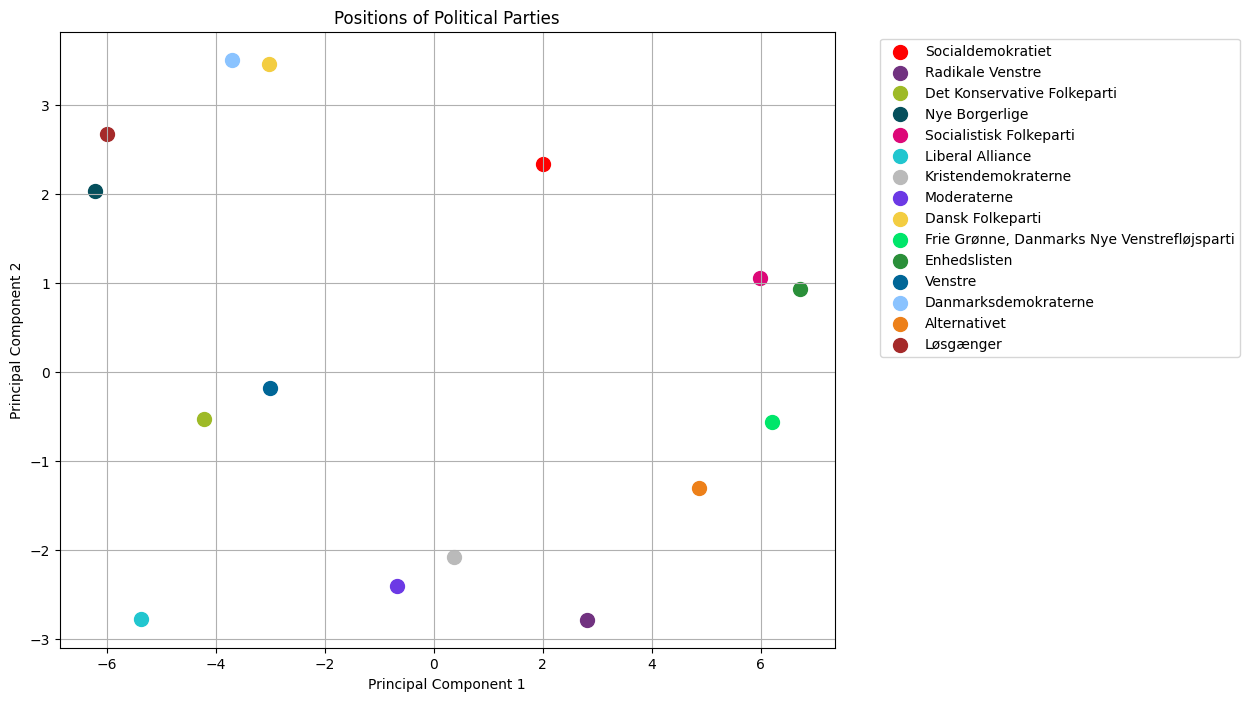

In [62]:
# Visualize the positions of the parties in the reduced-dimensional space
plt.figure(figsize=(10, 8))
for party, position in party_positions_df.iterrows():
    plt.scatter(position['PC1'], position['PC2'], color=party_colors_palette[party], label=party, s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Positions of Political Parties')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Position the legend outside the plot
plt.grid(True)
plt.show()


Hierarchical clustering

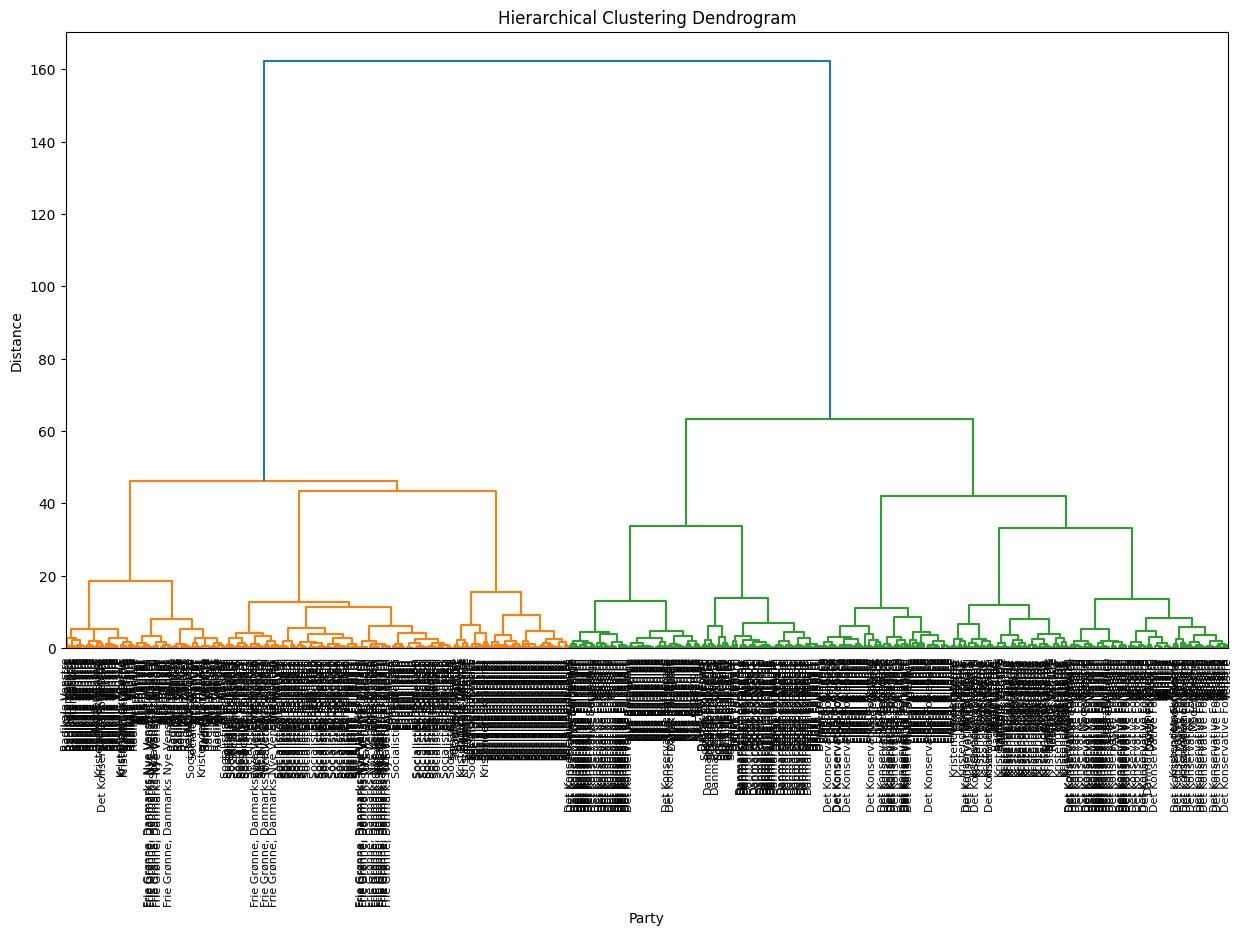

In [63]:
# Perform hierarchical clustering
linkage_matrix = linkage(components, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=cleaned_df['parti'].values, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Party')
plt.ylabel('Distance')
plt.show()

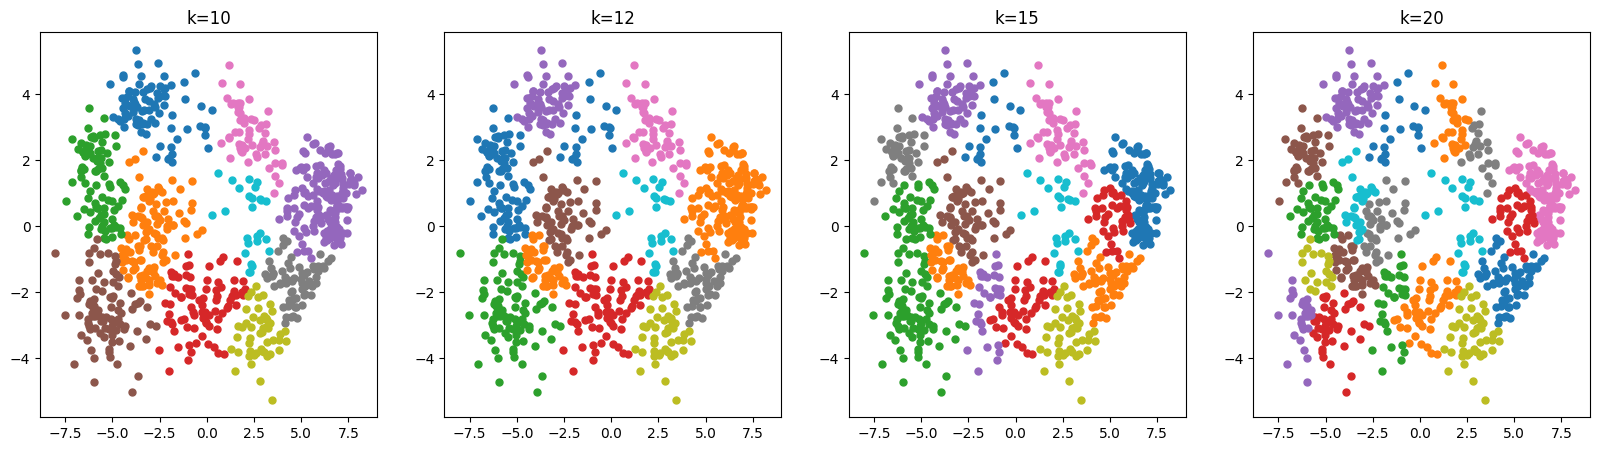

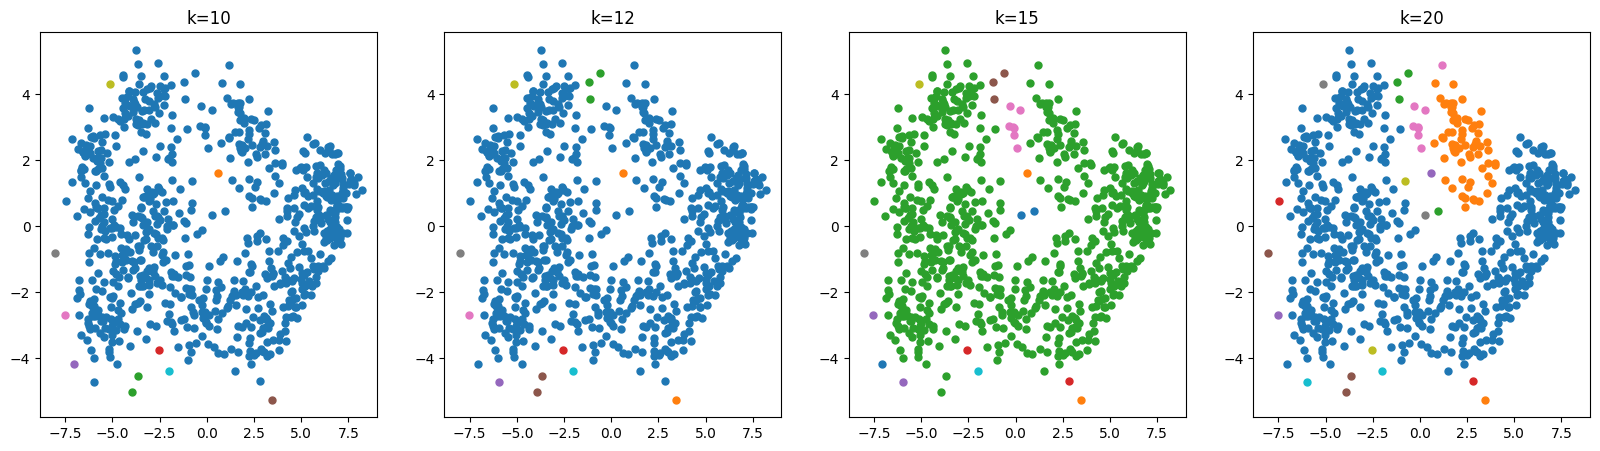

In [64]:
from sklearn.cluster import AgglomerativeClustering

def plot_agg_clustering(ks, method):
    
    fig, axes = plt.subplots(1,4, figsize = (20,5))
    for i, k in enumerate(ks):
        ax = axes[i]
        agg = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = agg.fit_predict(components)
        for label_id in range(k):
            ax.plot(components[labels == label_id, 0], components[labels == label_id, 1], '.', markersize=10, label=label_id)
        ax.set_title(f'k={k}')
    plt.show()

plot_agg_clustering([10, 12, 15, 20], 'ward')
plot_agg_clustering([10, 12, 15, 20], 'single')

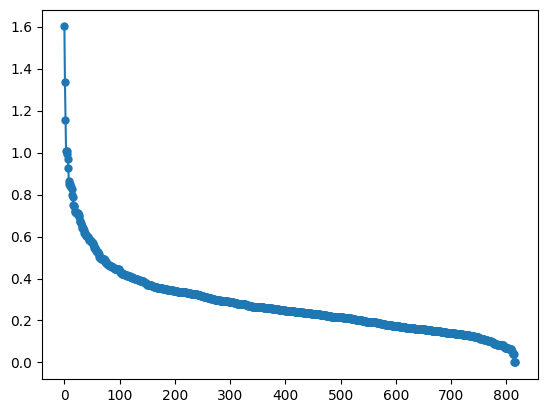

In [65]:
def calculate_k_distance(X,k):
    k_distance = []
    for i in range(len(X)):
        dist = []
        for j in range(len(X)):
            dist.append(np.linalg.norm(X[i,:]-X[j,:]))
        dist.sort()
        k_distance.append(dist[k])
    k_distance.sort(reverse=True)
    return k_distance


k = 2
k_distances = calculate_k_distance(components,k)
plt.plot(range(len(components)),k_distances,'.-', markersize=10)
plt.show()

DBSCAN clustering

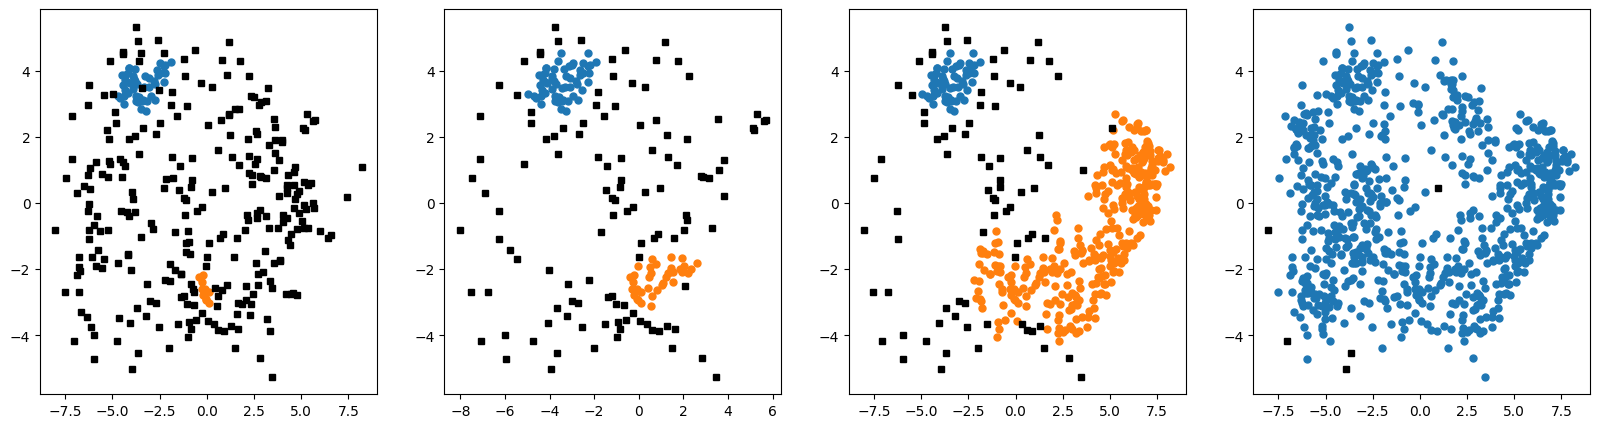

In [66]:
def plot_dbscan(eps):
    fig, axes = plt.subplots(1,4, figsize = (20,5))
    for i, ax in enumerate(zip(axes.ravel())):
        dbscan = DBSCAN(eps=eps[i], min_samples = 4)
        label = dbscan.fit_predict(components)
        for i in range(k):
            ax[0].plot(components[label == i , 0] , components[label == i , 1], '.', markersize=10, label = i)
        ax[0].plot(components[label == -1 , 0] , components[label == -1 , 1], 'sk', markersize=4, label = -1) #plot outliers as black squares
    plt.show()
    
plot_dbscan([0.3, 0.4, 0.45, 0.95])

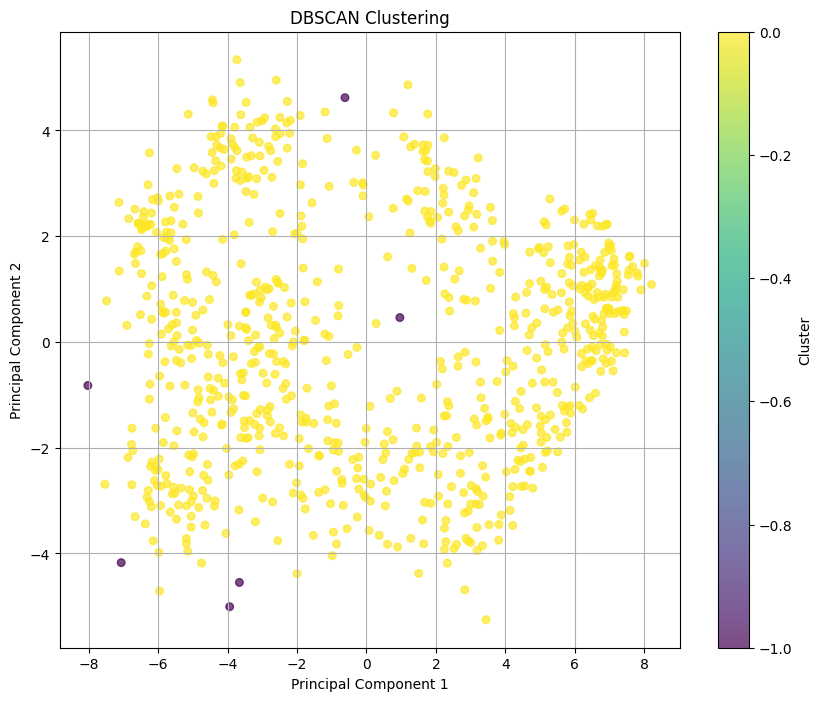

In [67]:
# We visualize the clusters by plotting the positions of individual candidates and coloring them based on their assigned cluster labels
# Perform DBSCAN clustering

dbscan = DBSCAN(eps=0.9, min_samples=5)
cluster_labels_dbscan = dbscan.fit_predict(components)

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(components[:, 0], components[:, 1], c=cluster_labels_dbscan, cmap='viridis', s=30, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()